In [1]:
import seagul.envs
import gym

env = gym.make('su_acro_drake-v0')

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import torch

from itertools import product
from multiprocessing import Pool
import time

total 0.06237626075744629
[999.99999963]


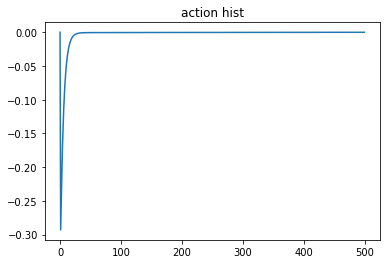

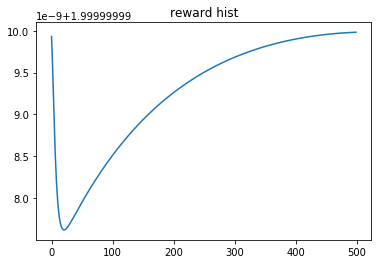

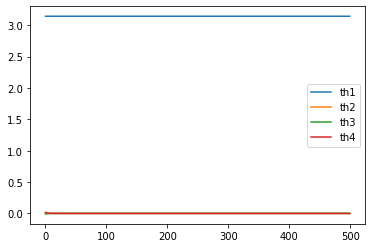

In [5]:
max_torque = 10

config = {"init_state" : [pi,0,0,0], "max_torque" : max_torque, 
    "init_state_weights" : [0,0,0,0], "dt" : .001,
    "fixed_step" : True, "int_accuracy" : .0001
    }

env = gym.make('su_acro_drake-v0', **config)
env.num_steps = 500

def control(q):
    #k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    #k = np.array([83.00702476, 27.2860448,  15.03836564,  3.12866625])
    #k = np.array([[100.48797281,  31.27961142,  18.25064425,   3.33078585]])
    #k =  np.array([1316.85, 555.42, 570.33, 272.58])
    k = np.array([[15.35216187,  4.15795716,  8.98067486,  0.9426521 ]])
    #k = np.array([[273.77508024,  60.79140205, 159.03558811,   9.1835837 ]])
    #k = np.array([[209.05320712,  39.21744438, 120.78197876,   2.97587759]])
    k = np.array([[266.08724059, 107.34926358, 114.95036444,  54.31747445]])
    k = np.array([[269.552, 67.522, 98.966, 29.057]])
    #k = np.array([[20968.62606848,  3315.72482626,  3671.02961993,    32.92386574]])
    #k =  np.array([1316.85, 555.42, 570.33, 272.58])
    #k = np.array([204.06707408,  59.21086694,  37.41566423,   5.29518038])

    #k = np.array([[10.44, 3.561, 2.778, 1.301]])
    #k = 
    #import ipdb; ipdb.set_trace()
    gs = np.array([pi,0,0,0])
    #return 0
    return -k.dot(gs - q)


pol = torch.load('warm/LQR_policy')
action_hist = np.zeros((env.num_steps,1))
action2_hist = np.zeros((env.num_steps,1))

state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
obs = env.reset() 

import time
start = time.time()
for i in range(env.num_steps):
        actions = np.clip(np.asarray(control(obs)),-max_torque, max_torque)
        action2_hist[i,:] = actions
        
        #obs = torch.as_tensor(obs, dtype=torch.float32)
        #actions = np.clip(np.asarray(pol(obs).detach()),-max_torque, max_torque)
        
        obs, reward, done, _ = env.step(actions)
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
       # if done:
       #     break
            
print("total", time.time() - start)

plt.plot(action_hist)
plt.title('action hist')

plt.figure()
plt.plot(reward_hist)
plt.title('reward hist')

plt.figure()
plt.plot(state_hist)
plt.legend(['th1', 'th2', 'th3', 'th4'])


print(sum(reward_hist))

289.67876410484314


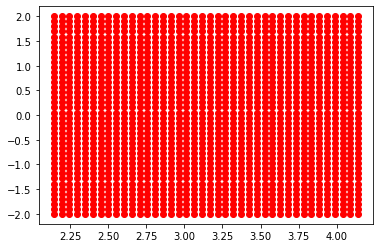

In [8]:
env = gym.make('su_acro_drake-v0',**config)
env.num_steps = 20000

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
obs = env.reset(init_vec = [.01,0,0,0]) 

th1_min = pi-1; th1_max = pi+1; num_th1 = 40 
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th2_min = -2; th2_max = 2; num_th2 = 40
th2_vals = np.linspace(th2_min, th2_max, num_th2)



results = np.zeros((th1_vals.size, th2_vals.size))
rewards = np.zeros((th1_vals.size, th2_vals.size))

import time
start = time.time()

def do_rollout(th):
    th1,th2 = th
    obs = env.reset(init_vec = [th1, th2, 0, 0])
    reward_hist = []
    for i in range(env.num_steps):
        actions = np.clip(np.asarray(control(obs)), -max_torque, max_torque)
        obs, reward, done, _ = env.step(actions)
        reward_hist.append(np.copy(reward))
        
    return sum(reward_hist)

pool = Pool() #defaults to number of available CPU's
for ind, res in enumerate(pool.imap(do_rollout, product(th1_vals, th2_vals)),1):
        results.flat[ind-1] = res > env.num_steps*2-50
        rewards.flat[ind-1] = res
       
end = time.time()
print(end - start)

for i,ival in enumerate(results[:,:]):
    for j,val in enumerate(ival):
            #plt.plot(th1_vals[i], slope*(th1_vals[i]-pi), 'o', color='blue')

            if val:
                plt.plot(th1_vals[i], th2_vals[j], 'o', color = 'green')
            else:
                plt.plot(th1_vals[i], th2_vals[j], 'o', color='red')

24.997556447982788


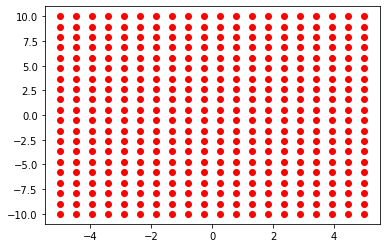

In [4]:
env = gym.make('su_acro_drake-v0', **config)
env.num_steps = 500

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))

th1dot_min = -5; th1dot_max = 5; num_th1dot = 20
th1dot_vals = np.linspace(th1dot_min, th1dot_max, num_th1dot)

th2dot_min = -10; th2dot_max = 10; num_th2dot = 20
th2dot_vals = np.linspace(th2dot_min, th2dot_max, num_th2dot)

results4 = np.zeros((th1dot_vals.size, th2dot_vals.size))
rewards = np.zeros((th1dot_vals.size, th2dot_vals.size))

import time
start = time.time()

for th1dot_i, th1dot in enumerate(th1dot_vals):
        for th2dot_i, th2dot in enumerate(th2dot_vals):
            obs = env.reset(init_vec = [pi, 0, th1dot, th2dot])
            for i in range(env.num_steps):
                actions = np.clip(np.asarray(control(obs)), -max_torque,max_torque)
                obs, reward, done, _ = env.step(actions)
                action_hist[i,:] = np.copy(actions)
                state_hist[i,:] = np.copy(obs)
                reward_hist[i,:] = np.copy(reward)

            results4[th1dot_i, th2dot_i] = sum(reward_hist) > env.num_steps*2-50
            rewards[th1dot_i, th2dot_i] = sum(reward_hist)

end = time.time()
print(end - start)

for i,ival in enumerate(results4):
    for j,val in enumerate(ival):
            #plt.plot(th1_vals[i], slope*(th1_vals[i]-pi), 'o', color='blue')
            if val:
                plt.plot(th1dot_vals[i], th2dot_vals[j], 'o', color = 'green')
            else:
                plt.plot(th1dot_vals[i], th2dot_vals[j], 'o', color='red')

In [8]:
th1_min = pi-1; th1_max = pi+1; num_th1 = 40
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th2_min = -2; th2_max = 2; num_th2 = 40
th2_vals = np.linspace(th2_min, th2_max, num_th2)

th1dot_min = -.5; th1dot_max = .5; num_th1dot = 1
th1dot_vals = np.linspace(th1dot_min, th1dot_max, num_th1dot)

th2dot_min = -.5; th2dot_max = .5; num_th2dot = 1
th2dot_vals = np.linspace(th2dot_min, th2dot_max, num_th2dot)

results3 = np.zeros((th1_vals.size, th2_vals.size, th1dot_vals.size, th2dot_vals.size))

for th1_i, th1 in enumerate(th1_vals):
    for th2_i, th2 in enumerate(th2_vals):
        for th1d_i, th2d in enumerate(th1dot_vals):
            for th2d_i, th2d in enumerate(th2dot_vals):
                results3[th1_i, th2_i, th1d_i, th2d_i] = 0

In [47]:
env = gym.make('su_acro_drake-v0', **config)
env.num_steps = 150
slope = -2.3636363636363638 #empirically determined from the above

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))

th1_min = pi-.5; th1_max = pi+.5; num_th1 = 5
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th1dot_min = -5; th1dot_max = 5; num_th1dot = 15
th1dot_vals = np.linspace(th1dot_min, th1dot_max, num_th1dot)

th2dot_min = -15; th2dot_max = 15; num_th2dot = 15
th2dot_vals = np.linspace(th2dot_min, th2dot_max, num_th2dot)

results2 = np.zeros((th1_vals.size, 1, th1dot_vals.size, th2dot_vals.size))
rewards = np.zeros((th1_vals.size, 1, th1dot_vals.size, th2dot_vals.size))

import time
start = time.time()

for th1_i, th1 in enumerate(th1_vals):
    for th1dot_i, th1dot in enumerate(th1dot_vals):
            for th2dot_i, th2dot in enumerate(th2dot_vals):
                obs = env.reset(init_vec = [th1, slope*(th1-pi), th1dot, th2dot])
                for i in range(env.num_steps):
                    actions = np.clip(np.asarray(control(obs)), -max_torque,max_torque)
                    obs, reward, done, _ = env.step(actions)
                    action_hist[i,:] = np.copy(actions)
                    state_hist[i,:] = np.copy(obs)
                    reward_hist[i,:] = np.copy(reward)

                results2[th1_i, 0, th1dot_i, th2dot_i] = sum(reward_hist) > 250
                rewards[th1_i, 0, th1dot_i, th2dot_i] = sum(reward_hist)

end = time.time()
print(end - start)



20.949931859970093


In [ ]:
fig, axs = plt.subplots(th1dot_vals.shape[0], th2dot_vals.shape[0], figsize =(15,15))

# Gross
for th1di ,th1d in enumerate(th1dot_vals):
    for th2di, th2d in enumerate(th2dot_vals):
        axs[th1di, th2di].set_title(str(th1d) + " " + str(th2d))
        for i,ival in enumerate(results2[:,:,th1di,th2di]):
            for j,val in enumerate(ival):
                if val:
                    axs[th1di, th2di].plot(th1_vals[i], slope*(th1_vals[i]-pi), 'o', color = 'green')
                else:
                     axs[th1di, th2di].plot(th1_vals[i], slope*(th1_vals[i]-pi), 'o', color='red')
          

In [ ]:
#X = []
#Y = []

for result in results:
    for i,ival in enumerate(result):
        for j,jval in enumerate(ival):
            for k,kval in enumerate(jval):
                X.append((th1_vals[i], slope*(th1_vals[i]-pi), th1dot_vals[j], th2dot_vals[k]))
                Y.append(kval)
                
                
X = []
Y = []

count = 0
for i,result in enumerate(results):
    for j,jval in enumerate(result):    
        count += 1
        X.append((th1_vals[i], th2_vals[j], 0, 0))
        Y.append(jval)

In [ ]:
import pickle
pickle.dump(X, open('./warm/X_zv_128', 'wb'))
pickle.dump(Y, open('./warm/Y_zv_128', 'wb'))

In [ ]:
env = gym.make('su_acro_drake-v0')
env.num_steps = 500

def control(q):
    k =  np.array([1316.85, 555.42, 570.33, 272.58])
    #k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    #k = np.array([[10.44, 3.561, 2.778, 1.301]])
    #import ipdb; ipdb.set_trace()
    gs = np.array([pi,0,0,0])
    #return 0
    return -k.dot(gs - q)

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
obs = env.reset(init_vec = [0,0,0,0]) 

th1_min = 0; th1_max = 2*pi; num_th1 = 64
th1_vals = np.linspace(th1_min, th1_max, num_th1)

th2_min = -pi; th2_max = pi; num_th2 = 64
th2_vals = np.linspace(th2_min, th2_max, num_th2)

th1dot_min = -1; th1dot_max = 1; num_th1dot = 3
th1dot_vals = np.linspace(th1dot_min, th1dot_max, num_th1dot)
#th1dot_vals = np.zeros(1)

th2dot_min = -1; th2dot_max = 1; num_th2dot = 3
th2dot_vals = np.linspace(th2dot_min, th2dot_max, num_th2dot)
#th2dot_vals = np.zeros(1)


th1_eval_min = pi-1; th1_eval_max = pi+1
th2_eval_min = -2; th2_eval_max = 2

results = np.zeros((th1_vals.size, th2_vals.size, th1dot_vals.size, th2dot_vals.size))
rewards = np.zeros((th1_vals.size, th2_vals.size, th1dot_vals.size, th2dot_vals.size))


import time
start = time.time()

in_count = out_count = 0
for th1_i, th1 in enumerate(th1_vals):
    for th2_i, th2 in enumerate(th2_vals):
        for th1dot in th1dot_vals:
            for th2dot in th2dot_vals:
                in_count += 1
                if th1_eval_min < th1 < th1_eval_max and th2_eval_min < th2 < th2_eval_max and th1dot == 0 and th2dot == 0:
                    obs = env.reset(init_vec = [th1, th2, 0, 0])
                    for i in range(env.num_steps):
                        actions = np.clip(np.asarray(control(obs)), -25, 25)
                        obs, reward, done, _ = env.step(actions)
                        action_hist[i,:] = np.copy(actions)
                        state_hist[i,:] = np.copy(obs)
                        reward_hist[i,:] = np.copy(reward)


                    results[th1_i, th2_i,0,0] = sum(reward_hist) > 900
                    rewards[th1_i, th2_i,0,0] = sum(reward_hist)
                else:
                    out_count += 1
                    results[th1_i, th2_i,0,0] = 0.
                    rewards[th1_i, th2_i,0,0] = 0.


end = time.time()
print(end - start)
print(in_count)
print(out_count)

In [9]:
from seagul.nn import MLP
pol = MLP(4,1,0,0,input_bias = True)
d = pol.state_dict()
d['output_layer.weight'] = torch.tensor([[1316.85, 555.42, 570.33, 272.58]], dtype=torch.float32)
d['output_layer.bias'] = torch.tensor([0.0],dtype=torch.float32)
d['input_bias'] = torch.tensor([-np.pi, 0.0, 0.0, 0.0], dtype=torch.float32)
pol.load_state_dict(d)
torch.save(pol, 'warm/LQR_policy')